In [659]:
import numpy as np
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.environ import Constraint
import logging

In [660]:
%matplotlib inline
logging.basicConfig(level="INFO")

# Power-to Gas Συστήματα
Τα συστήματα Power-to-Gas (P2G) αναπτύσσονται ως μια καινοτόμος τεχνολογία αποθήκευσης ενέργειας και μετατροπής περιβαλλοντικά φιλικών πηγών ενέργειας σε αέρια καύσιμα. Τα συστήματα P2G χρησιμοποιούν περίσσεια παραγωγή ενέργειας από ανανεώσιμες πηγές, όπως η αιολική και η ηλιακή ενέργεια, για την παραγωγή υδρογόνου ή μεθανίου. Αυτά τα καύσιμα μπορούν να αποθηκευτούν και να χρησιμοποιηθούν αργότερα για την παραγωγή ηλεκτρισμού ή ως καύσιμα για οχήματα με καύση καυσίμων.

### Δεδομένα Παραγωγής ΑΠΕ
Για τα δεδομένα παραγωγής ΑΠΕ χρησιμοποιήθηκε το αρχείο "RESMVLVPROD" του ΑΔΜΗΕ για την περίοδο 01-05-2020 - 31-10-2020.\
Το αρχειο περιλαμβάνει την συνολική παραγωγή ΑΠΕ της χώρας για τον λόγο αυτό τροποποιήθηκε με αναλογία 1:2000.\
Υποθέτουμε ότι η παραγωγή αφορά **μια περοχη ταδε** 

In [661]:
prod=pd.read_csv("RESMVLVPROD_20201001_20201031 (1).csv")
# Convert the date and hour columns to strings
prod['DATE'] = prod['DATE'].astype(str)
prod['HOUR'] = prod['HOUR'].astype(str)
# Pad the hour values with leading zeros if necessary
prod['HOUR'] = prod['HOUR'].str.zfill(2)
# Adjust hour '24' to '00' and increment the date by one DATE
prod.loc[prod['HOUR'] == '24', 'HOUR'] = '00'
prod['DATE'] = pd.to_datetime(prod['DATE'], format='%Y%m%d')
prod.loc[prod['HOUR'] == '00', 'DATE'] += pd.DateOffset(days=1)
prod['DATE'] = prod['DATE'].dt.strftime('%Y-%m-%d')
prod['datetime'] = prod['DATE'] + ' ' + prod['HOUR'] + ':00:00'
prod['datetime'] = pd.to_datetime(prod['datetime'])
prod.set_index(['datetime'],inplace=True)
start_date = pd.Timestamp('2020-09-11 12:00:00')
end_date = pd.Timestamp('2020-09-14 00:00:00')
prod=prod[start_date:end_date]
prod['ENERGY(MWh)']=prod['ENERGY(MWh)']/2000
#prod
 

## Δεδομένα Κατανάλωσης 
Αναλόγως με τα προηγόυμενα για τα δεδομένα ζήτησης χρησιμοποιήθηκε το αρχείο "HVCUSTCONS" του ΑΔΜΗΕ για την περίοδο 01-05-2020 - 31-10-2020.

In [662]:
cons = pd.read_csv("HVCUSTCONS_20201001_20201031 (1).csv")
#20201025,25,724.9618378,37.28140312
# Convert the date and hour columns to strings
cons['date'] = cons['date'].astype(str)
cons['hour'] = cons['hour'].astype(str)

# Pad the hour values with leading zeros if necessary
cons['hour'] = cons['hour'].str.zfill(2)

# Adjust hour '24' to '00' and increment the date by one day
cons.loc[cons['hour'] == '24', 'hour'] = '00'
cons['date'] = pd.to_datetime(cons['date'], format='%Y%m%d')
cons.loc[cons['hour'] == '00', 'date'] += pd.DateOffset(days=1)
cons['date'] = cons['date'].dt.strftime('%Y-%m-%d')

# Merge the date and hour columns
cons['datetime'] = cons['date'] + ' ' + cons['hour'] + ':00:00'

# Optionally, convert the 'datetime' column to a datetime data type
cons['datetime'] = pd.to_datetime(cons['datetime'])
cons.set_index(['datetime'],inplace=True)
start_date = pd.Timestamp('2020-09-11 12:00:00')
end_date = pd.Timestamp('2020-09-14 00:00:00')
cons=cons[start_date:end_date]
cons['energy(MWh)']=cons['energy(MWh)']/1000
#cons

## Υλοποίηση Συστήματος 
Για την διαμόρφωση του δικτύου χρησιμοποιήσαμε την βιβλιοθήκη pypsa της python.\
Το δίκυο αποτελείται από: 
- Τρεις ζυγούς (2 παραγωγής, 1 ζήτησης)
- 2 links για ηλεκτρολυτη και fuel cell
- 1 H2 buffer\
Οι ζυγοί συνδέονται μεταξυ τους μπλα μπλα
Η γεννήτρια έχει ταδε χαρακτηριστικα 
Το παρκο εχει ταδε χαρακτηριστικα

In [663]:
network = pypsa.Network()
network.set_snapshots(prod.index)

In [664]:
#Add buses and carriers to the network
network.add("Bus", "Coal", carrier='AC')
network.add("Carrier", "coal",co2_emissions=0.2)

#network.add("Bus", "Solar", carrier="AC")
network.add("Carrier", "solar")

#network.add("Bus","Load Bus")

#Add lines
#network.add("Line","Line1",bus0="Coal",bus1="Load Bus",r=0.01,x=0.1)
#network.add("Line","Line2",bus0="Solar",bus1="Load Bus",r=0.01,x=0.1)
#network.add("Line","Line3",bus0="Load Bus",bus1="Hydrogen",r=0.01,x=0.1)

network.add("GlobalConstraint", "co2_limit", sense="<=", constant=0.2)

#Add generators
network.add(
    "Generator",
    "Coal Gen",
    bus="Coal",
    carrier="coal",
    p_nom=0.5, 
    p_nom_extendable=True,
    #committable=True,
    p_set=0.5,
    #p_nom_min=0,
    p_nom_max=2,
    control="PQ",
    capital_cost=100, #currency/MW Capital cost of extending p_nom by 1 MW.
    marginal_cost=10  #currency/MWh 
    )

network.add(
    "Generator",
    "PV Park",
    bus="Coal",
    carrier="solar",
    control="PQ", 
    p_nom=1, #MW 
    p_nom_max=6,
    p_nom_extendable=True,
    #committable=True,
    #p_set=np.array(prod['ENERGY(MWh)']),
    p_max_pu=np.array(prod['ENERGY(MWh)']),
    #p_min_pu=np.array(prod['ENERGY(MWh)']),
    capital_cost=100, #currency/MW Capital cost of extending p_nom by 1 MW.
    marginal_cost=10  #currency/MWh

    )

#Add loads
network.add("Load", "load 1", bus="Coal", p_set=np.array(cons['energy(MWh)']))
#network.buses.loc[["Coal"], "p_set"] = 1

In [665]:
#network.lpf()
#network.generators_t.p.plot()
#network.loads_t.p.plot()

## Power-to-Hydrogen 
προσθετουμε το υδρογονο
- λινκ ηλεκτρολυσης με ταδε χαρακτηριστικα που βρηκα απο ταδε πηγες
- λινκ φιουελ σελ ">>"
- αποθήκευση

In [666]:
network.add("Bus", "Hydrogen", carrier="hydrogen")

network.add("Carrier", "hydrogen")
network.add("Carrier", "electrolysis")
network.add("Carrier", "fuel cell")
#network.add("Carrier", "H2 store")

#network.add('Load', "load4", bus='Hydrogen', p_set=0.5)
#network.add("Line","Line3",bus0="Load Bus",bus1="Hydrogen",r=0.01,x=0.1)
#network.add("Line","Line4",bus1="Hydrogen",bus0="Solar",r=0.01,x=0.1)

#Add electrolysis and fuel cell links
network.add(
    "Link",
    "Electrolysis",
    bus0="Coal",
    bus1="Hydrogen",
    carrier="electrolysis",
    efficiency=0.7, #according to ""
    p_nom=1, #Limit of active power which can pass through link.
    p_nom_extendable=True,
    p_nom_max=2,
    p_min_pu=0.2,
    p_max_pu=1,
    capital_cost=1000, #currency/MW 800000
    marginal_cost=10 ,#currency/MWh
    lifetime=20,
    )    

network.add(
    "Link",
    "Fuel Cell",
    bus0="Hydrogen",
    bus1="Coal",
    carrier="fuel cell",
    efficiency=0.5,
    p_nom=0.7, #Limit of active power which can pass through link.
    p_nom_max=1.5,
    p_nom_extendable=True,
    capital_cost=1000, #currency/MW 600000	Capital cost of extending p_nom by 1 MW.
    marginal_cost= 10,#currency/MWh 	Marginal cost of transfering 1 MWh (before efficiency losses) from bus0 to bus1. NB: marginal cost only makes sense if p_max_pu >= 0.
    lifetime=20,
    )

#Add H2 store
network.add(
    "Store", 
    "H2", 
    bus="Hydrogen", 
    carrier="hydrogen", 
    e_nom = 10, #Nominal energy capacity (MWh)
    e_cyclic=True, 
    e_nom_extendable=True,
    #e_nom_min= 0.5  , #MWh
    e_nom_max= 100, #MWh
    capital_cost=10000, #currency/MW
    marginal_cost=10 ,#currency/MWh    
    )


## Ροη φορτιου και βελτιστοποιηση


In [667]:
#network.lopf(pyomo=True)# snapshots=network.snapshots,extra_functionality=constraint,keep_files=True
network.optimize(network.snapshots, solver_name="glpk", solver_options={})#

<__array_function__ internals>:200: RuntimeWarning:

invalid value encountered in cast

<__array_function__ internals>:200: RuntimeWarning:

invalid value encountered in cast

<__array_function__ internals>:200: RuntimeWarning:

invalid value encountered in cast

INFO:linopy.model: Solve linear problem using Glpk solver
INFO:linopy.io: Writing time: 0.27s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 372 primals, 804 duals
Objective: 3.85e+04
Solver model: not available
Solver message: optimal



GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --lp C:\Users\2F06~1\AppData\Local\Temp\linopy-problem-ajfj_lso.lp --output
 C:\Users\2F06~1\AppData\Local\Temp\linopy-solve-momol7qo.sol
Reading problem data from 'C:\Users\2F06~1\AppData\Local\Temp\linopy-problem-ajfj_lso.lp'...
804 rows, 372 columns, 1657 non-zeros
5576 lines were read
GLPK Simplex Optimizer, v4.65
804 rows, 372 columns, 1657 non-zeros
Preprocessing...
550 rows, 371 columns, 1403 non-zeros
Scaling...
 A: min|aij| =  7.534e-02  max|aij| =  1.039e+00  ratio =  1.379e+01
GM: min|aij| =  6.654e-01  max|aij| =  1.503e+00  ratio =  2.258e+00
EQ: min|aij| =  4.472e-01  max|aij| =  1.000e+00  ratio =  2.236e+00
Constructing initial basis...
Size of triangular part is 549
      0: obj =  -1.013652022e+05 inf =   8.672e+01 (61)
    181: obj =   4.315092526e+04 inf =   0.000e+00 (0) 1
*   208: obj =   3.851215577e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 

('ok', 'optimal')

## Περιορισμοι

In [668]:
#network.model
#network.optimize.solve_model()

## Αποτελέσματα και Σχόλια

In [669]:
#total system cost for the snapshots optimised.
network.objective 

38512.15577

In [670]:
#network.iplot()

<Axes: xlabel='datetime'>

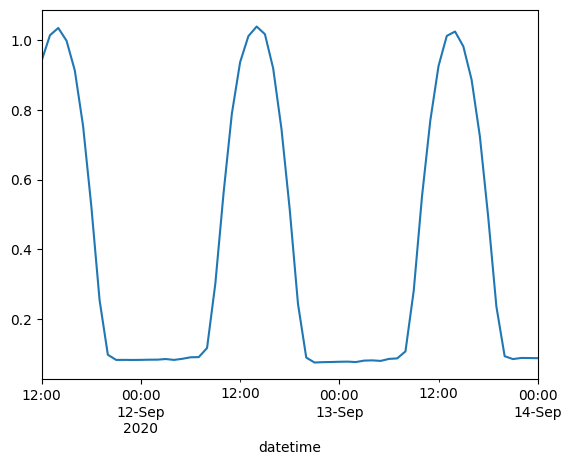

In [671]:
prod['ENERGY(MWh)'].plot()

<Axes: xlabel='snapshot', ylabel='ΜWh'>

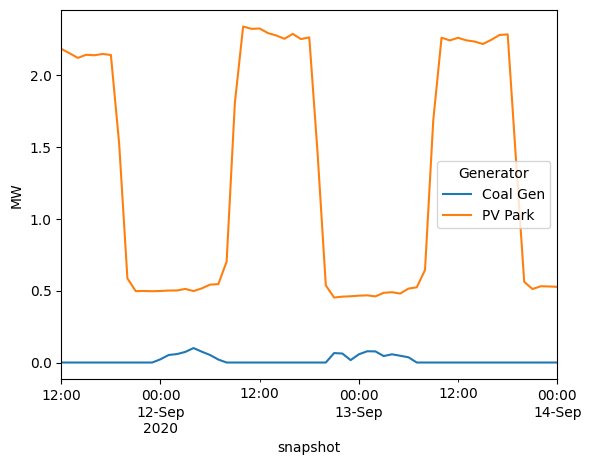

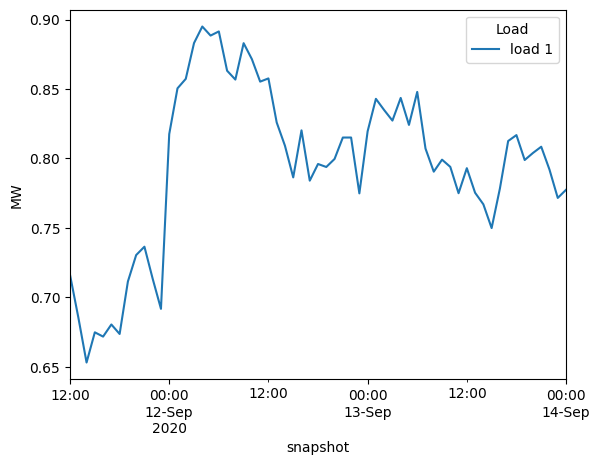

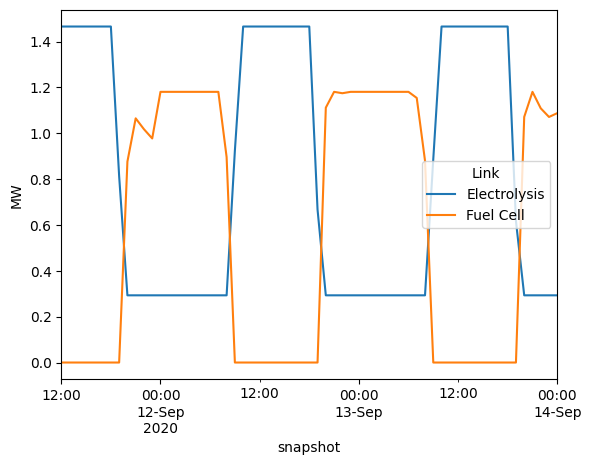

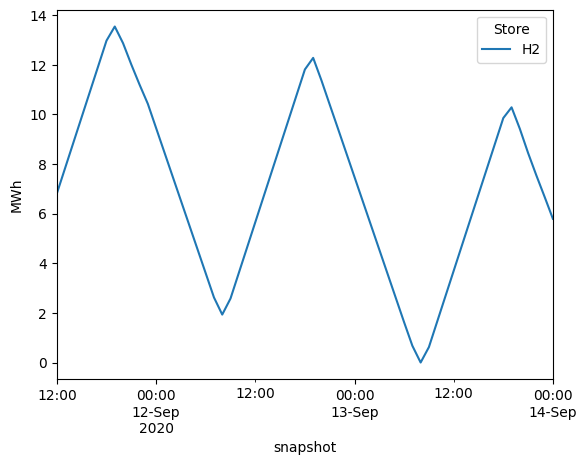

In [672]:
#network.buses_t.p.plot()
network.generators_t.p.plot(ylabel='ΜW')
network.loads_t.p.plot(ylabel='ΜW')
network.links_t.p0.plot(ylabel='ΜW')
network.stores_t.e.plot(ylabel='ΜWh')